In [7]:
from pathlib import Path
import numpy as np
import librosa
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

from utils import get_tokenizer_valid_len, extract_text_features

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载所有被试听21styear故事时的fMRI响应
fmris = np.load('21styear_all_subs_rois.npy', allow_pickle=True).item()
n_trs = fmris[75].shape[0]  # TR数量

print(len(fmris))
print(fmris.keys())
print(fmris[75].shape)  # (TRs, ROIs)

# 读入csv文件, cased/uncased为文本, start_ts/end_ts为单词起始和结束时刻
df = pd.read_csv('21styear_align.csv', header=None, names=["cased", "uncased", "start_ts", "end_ts"])

df.cased = df.cased.fillna("none")
df.end_ts = df.end_ts.bfill()
df.start_ts = df.start_ts.bfill()

# time (s) -> TR (1.5s)
df['tr'] = df.start_ts.apply(lambda x: np.ceil(x / 1.5).astype(int))
print(df.shape) # (num_words, 5)

df.head()

25
dict_keys([75, 131, 190, 201, 235, 244, 249, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271])
(2249, 360)
(8267, 5)


,cased,uncased,start_ts,end_ts,tr
0,This,this,21.219999,21.289999,15
1,is,is,21.460000,21.650000,15
2,Los,los,21.660000,21.940000,15
3,Angeles,angeles,21.940000,22.770000,15
4,And,and,22.810000,22.960000,16


In [2]:
import numpy as np
from pathlib import Path


def load_features(
    model_type: str,
    feature_dir: Path,
    *,
    layer: int = None,
    ctx_words: int = None,
    tr_wav_win: int = None,
    prefix: str = None,
):
    """
    通用特征加载函数，支持 GPT / HuBERT / CLAP

    Parameters
    ----------
    model_type : str
        "gpt", "hubert", "clap"
    feature_dir : Path
        特征文件所在目录
    layer : int, optional
        GPT / HuBERT 所需层号
    ctx_words : int, optional
        GPT 上下文窗口大小
    tr_wav_win : int, optional
        HuBERT / CLAP 时间窗口
    prefix : str, optional
        自定义文件名前缀（不传则使用默认）

    Returns
    -------
    np.ndarray
        加载的特征
    """

    model_type = model_type.lower()

    if model_type == "gpt":
        if ctx_words is None or layer is None:
            raise ValueError("GPT 特征需要提供 ctx_words 和 layer")

        prefix = prefix or "gpt2_21styear"
        filename = f"{prefix}_win{ctx_words}_layer{layer}_features.npy"

    elif model_type == "hubert":
        if tr_wav_win is None or layer is None:
            raise ValueError("HuBERT 特征需要提供 tr_wav_win 和 layer")

        prefix = prefix or "hubert_21styear"
        filename = f"{prefix}_trwin{tr_wav_win}_layer{layer}_features.npy"

    elif model_type == "clap":
        if tr_wav_win is None:
            raise ValueError("CLAP 特征需要提供 tr_wav_win")

        prefix = prefix or "clap_multimodal_21styear"
        filename = f"{prefix}_trwin{tr_wav_win}_features.npy"

    else:
        raise ValueError(
            f"Unsupported model_type: {model_type}. "
            f"Choose from ['gpt', 'hubert', 'clap']"
        )

    feature_path = feature_dir / filename

    if not feature_path.exists():
        raise FileNotFoundError(f"Feature file not found: {feature_path}")

    feats = np.load(feature_path)
    return feats

#示例
aligned_tr_feats = load_features(
    model_type="hubert",
    feature_dir=Path('.'),
    tr_wav_win=2 ,
    layer = 6
)
#重要的名称定义
modelname = 'hubert'
print(aligned_tr_feats.shape)

(2249, 768)


In [3]:
# PCA降维特征
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
aligned_feats_std = scaler.fit_transform(aligned_tr_feats)
pca = PCA(n_components=250)
aligned_tr_feats = pca.fit_transform(aligned_feats_std)
aligned_tr_feats.shape

#建模血氧动力学延迟
from utils import concat_feature
 
fir_features = concat_feature(aligned_tr_feats, window=4, offset=7)
fir_features = fir_features.reshape(fir_features.shape[0], -1)
fir_features.shape

(2249, 1000)

In [ ]:
#对所有被试进行计算统计

import numpy as np
from utils import fit_encoding_cv
from sklearn.model_selection import KFold

# --- 1. 数据加载 (保持不变) ---
fmris = np.load('21styear_all_subs_rois.npy', allow_pickle=True).item()

# 假设 fir_features 在此之前已被加载
# fir_features = ... 

# --- 2. 参数设置 (保持不变) ---
kfold = 5
# 使用 shuffle=True 通常更合适，但在原始代码中为 False，这里保持一致
outer_cv = KFold(n_splits=kfold, shuffle=False) 
# 正则化参数 alpha 的搜索范围
alphas = [10000., 100000., 1000000.]
# 排除开头和结尾的 TR 以避免边界效应
excluded_start, excluded_end = 10, 10

# --- 3. 多被试分析的初始化 ---
# 获取所有被试的ID (即 fmris 字典中的所有键)
all_subjects = list(fmris.keys())
# 存储每个被试的平均交叉验证相关性
all_sub_results = {} # 存储 {sub_id: {'mean_corr': float, 'corr_map': array}}
all_sub_scores = [] 

print(f"--- Starting analysis for {len(all_subjects)} subjects ---")

for sub in all_subjects:
    print(f'\nFitting encoding model for Subject {sub}...')
    
    try:
        model, corr_map = fit_encoding_cv(
            X=fir_features,
            y=fmris[sub],
            cv_splitter=outer_cv,
            alphas=alphas,
            excluded_start=excluded_start,
            excluded_end=excluded_end
        )

        mean_cv_corr = np.mean(corr_map)
        all_sub_scores.append(mean_cv_corr) 
        print(f'Subject {sub} fitted. mean CV corr: {mean_cv_corr:.3f}')
        
        # --- 关键修改：保存corr_map ---
        all_sub_results[sub] = {
            'mean_corr': mean_cv_corr,
            'corr_map': corr_map # 保存该被试的 ROI 相关系数数组
        }
        
    except Exception as e:
        print(f"An error occurred for Subject {sub}: {e}")
        continue


output_txt = f'encoding_accuracy_all_subjects_for_{modelname}.txt'

all_sub_scores = np.array(all_sub_scores)
mean_score = np.mean(all_sub_scores)
std_score = np.std(all_sub_scores)

with open(output_txt, 'w') as f:
    # 第一行：均值 ± 标准差
    f.write(f"Mean CV corr: {mean_score:.4f} ± {std_score:.4f}\n\n")

    # 每个被试一行
    for sub in all_sub_results:
        score = all_sub_results[sub]['mean_corr']
        f.write(f"Subject {sub}: {score:.4f}\n")

print(f"\nAccuracy summary saved to: {output_txt}")

--- Starting analysis for 25 subjects ---

Fitting encoding model for Subject 75...
Subject 75 fitted. mean CV corr: 0.172

Fitting encoding model for Subject 131...
Subject 131 fitted. mean CV corr: 0.123

Fitting encoding model for Subject 190...
Subject 190 fitted. mean CV corr: 0.126

Fitting encoding model for Subject 201...
Subject 201 fitted. mean CV corr: 0.127

Fitting encoding model for Subject 235...
Subject 235 fitted. mean CV corr: 0.138

Fitting encoding model for Subject 244...
Subject 244 fitted. mean CV corr: 0.094

Fitting encoding model for Subject 249...
Subject 249 fitted. mean CV corr: 0.154

Fitting encoding model for Subject 254...
Subject 254 fitted. mean CV corr: 0.110

Fitting encoding model for Subject 255...
Subject 255 fitted. mean CV corr: 0.177

Fitting encoding model for Subject 256...
Subject 256 fitted. mean CV corr: 0.135

Fitting encoding model for Subject 257...
Subject 257 fitted. mean CV corr: 0.098

Fitting encoding model for Subject 258...
Subj

In [5]:
#可视化
from brainspace.plotting.surface_plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from neuromaps.datasets import fetch_atlas
from utils import extract_hemi_data_from_files

fslr = fetch_atlas('fsaverage', '41k', data_dir='.')
# 读入表面模板文件，用于后续可视化
# inflated表示膨胀后的表面网格，fslr['inflated']是一个字典，包含左右两个表面文件的路径
# （pathlib.WindowsPath对象，需要转换成str）
surf_lh = read_surface(str(fslr['inflated'].L))
surf_rh = read_surface(str(fslr['inflated'].R))

path = Path('.')
tpl_files = list(path.glob('*MMP*gii'))
whole_brain_rois = extract_hemi_data_from_files(tpl_files, is_label=True, return_list=False).astype(int)

whole_brain_rois.shape

import os
import numpy as np 
# 假设 all_sub_results, whole_brain_rois, surf_lh, surf_rh, plot_hemispheres 函数已定义

# --- 1. 创建输出文件夹 ---
output_dir = f'./output/{modelname}/'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory created/verified at: {output_dir}")

# --- 2. 循环可视化和保存每个被试的脑图 ---
for sub, result in all_sub_results.items():
    corr_map = result['corr_map']
    mean_corr = result['mean_corr']
    
    # 1. 初始化全脑相关系数数组
    whole_brain_corrs = np.zeros(whole_brain_rois.shape, dtype=np.float32)

    # 2. 将 ROI 的相关系数映射到全脑数组的相应位置
    for roi_ind in np.unique(whole_brain_rois[whole_brain_rois != 0]):
        # roi_ind - 1 是 corr_map 中的索引
        whole_brain_corrs[whole_brain_rois == roi_ind] = corr_map[roi_ind - 1]

    # 3. 后处理：设置中脑壁和阈值
    whole_brain_corrs[whole_brain_rois == 0] = np.nan
    whole_brain_corrs[whole_brain_corrs < 0.] = np.nan
    
    # 4. 构造文件名和标签文本
    title_str = f"Subject {sub} | Mean CV Corr: {mean_corr:.3f}"

    # 文件名必须是“安全字符串”
    safe_title = title_str.replace(" ", "_").replace("|", "").replace(":", "")
    filename = f"{safe_title}.png"
    filepath = os.path.join(output_dir, filename)
    
    # 使用 label_text 在图上添加标题（可选，具体显示效果取决于库的实现）
    subject_label = {'top': f'Subject {sub} | Mean CV Corr: {mean_corr:.3f}'}

    # 5. 可视化并保存脑图
    print(f"Saving plot for Subject {sub} to {filepath}")
    
    plot_hemispheres(surf_lh, surf_rh,
                     array_name=whole_brain_corrs,
                     nan_color=(0.8, 0.8, 0.8, 1),
                     background=(1, 1, 1),
                     size=(1000, 300),
                     embed_nb=False, 
                     color_bar=False,
                     interactive=False, # 非交互模式，适用于截图
                     cmap='coolwarm',
                     zoom=1.2,
                     #label_text=subject_label, # 使用官方参数传递标签文本
                     transparent_bg=False, # 确保背景不透明，适用于截图
                     # --- 核心修改：使用正确的截图参数 ---
                     screenshot=True, # 启用截图模式
                     filename=filepath # 指定保存文件路径
                     )

print("\nAll subject brain maps have been successfully saved to the ./output/ folder.")

Output directory created/verified at: ./output/hubert/
Saving plot for Subject 75 to ./output/hubert/Subject_75__Mean_CV_Corr_0.172.png
Saving plot for Subject 131 to ./output/hubert/Subject_131__Mean_CV_Corr_0.123.png
Saving plot for Subject 190 to ./output/hubert/Subject_190__Mean_CV_Corr_0.126.png
Saving plot for Subject 201 to ./output/hubert/Subject_201__Mean_CV_Corr_0.127.png
Saving plot for Subject 235 to ./output/hubert/Subject_235__Mean_CV_Corr_0.138.png
Saving plot for Subject 244 to ./output/hubert/Subject_244__Mean_CV_Corr_0.094.png
Saving plot for Subject 249 to ./output/hubert/Subject_249__Mean_CV_Corr_0.154.png
Saving plot for Subject 254 to ./output/hubert/Subject_254__Mean_CV_Corr_0.110.png
Saving plot for Subject 255 to ./output/hubert/Subject_255__Mean_CV_Corr_0.177.png
Saving plot for Subject 256 to ./output/hubert/Subject_256__Mean_CV_Corr_0.135.png
Saving plot for Subject 257 to ./output/hubert/Subject_257__Mean_CV_Corr_0.098.png
Saving plot for Subject 258 to ./o

In [1]:
#拓展任务五

#加载所有特征
import os
import numpy as np

FEATURE_DIR = './npyall/'

feature_files = {
    'clap': 'clap_win4.npy',
    'whisper': 'whisper_win4_layer12_mean.npy',
    'imagebind':'imagebind_L11_features.npy',
    'wav2vec2': 'wav2vec2_layer7_win3.npy',
    'wavlm': 'wavlm_win4_layer9_mean.npy',
    'hubert': 'hubert_win4_layer9_mean.npy',
    'gpt' : 'gpt2_win200_layer10_Mlast_TRmax.npy',
    'deepseek':'deepseek_win200_layer10_Mlast_TRmax.npy',
    'qwen': 'qwen_win200_layer18_Mlast_TRmax.npy'
}

all_features = {}
for name, fname in feature_files.items():
    path = os.path.join(FEATURE_DIR, fname)
    all_features[name] = np.load(path)

print('Loaded features:')
for k, v in all_features.items():
    print(f'{k}: {v.shape}')


Loaded features:
clap: (2249, 1024)
whisper: (2249, 768)
imagebind: (2249, 1792)
wav2vec2: (2249, 768)
wavlm: (2249, 768)
hubert: (2249, 768)
gpt: (2249, 768)
deepseek: (2249, 2048)
qwen: (2249, 1536)


In [ ]:
#加权融合，设置不同的延迟时间

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from utils import concat_feature

# --- 配置参数 ---
target_dim = 250


configs = {
    'whisper': {'file': 'whisper_win4_layer12_mean.npy', 'offset': 5, 'weight': 0.4, 'window': 4},
    'qwen': {'file': 'qwen_win200_layer18_Mlast_TRmax.npy', 'offset': 7, 'weight': 0.6, 'window': 4}
}

processed_list = []

for name, cfg in configs.items():
    # 1. 加载
    path = os.path.join(FEATURE_DIR, cfg['file'])
    feat = np.load(path)
    print(f"Processing {name}, original shape: {feat.shape}")

    # 2. 标准化与 PCA 降维
    scaler = StandardScaler()
    feat_std = scaler.fit_transform(feat)
    
    pca = PCA(n_components=target_dim)
    feat_reduced = pca.fit_transform(feat_std)
    
    # 3. 建模血氧动力学延迟 (使用 concat_feature)
    # 该函数会生成形状为 (n_samples, window, target_dim) 的特征
    feat_delayed = concat_feature(feat_reduced, window=cfg['window'], offset=cfg['offset'])
    
    # 4. 展平特征以供回归模型使用 (n_samples, window * target_dim)
    feat_flattened = feat_delayed.reshape(feat_delayed.shape[0], -1)
    
    # 5. 应用权重并存储
    processed_list.append(feat_flattened * cfg['weight'])
    print(f"  -> After concat & weight, shape: {feat_flattened.shape}")

# --- 加权求和 ---
# 确保两个特征在时间维度（行数）上是对齐的
# 如果长度不一，需要取交集（通常出现在 offset 不同导致边缘缺失时）
min_len = min(processed_list[0].shape[0], processed_list[1].shape[0])
fir_features = processed_list[0][:min_len] + processed_list[1][:min_len]

print("-" * 30)
print(f"Final fir_features shape: {fir_features.shape}")
import numpy as np
from utils import fit_encoding_cv
from sklearn.model_selection import KFold


modelname = "whisper_qwen_hybrid"

# --- 1. 数据加载 ---
fmris = np.load('21styear_all_subs_rois.npy', allow_pickle=True).item()

# --- 2. 参数设置 ---
kfold = 5
outer_cv = KFold(n_splits=kfold, shuffle=False) 
alphas = [10000., 100000., 1000000.]
excluded_start, excluded_end = 10, 10

# --- 3. 多被试分析 ---
all_subjects = list(fmris.keys())
all_sub_results = {} 
all_sub_scores = [] 

print(f"--- Starting analysis for {len(all_subjects)} subjects ---")

for sub in all_subjects:
    # 自动检查特征和fmri长度是否匹配
    if fir_features.shape[0] != fmris[sub].shape[0]:
        print(f"Error: Subject {sub} length mismatch! Feature: {fir_features.shape[0]}, fMRI: {fmris[sub].shape[0]}")
        continue

    print(f'\nFitting encoding model for Subject {sub}...')
    
    try:
        model, corr_map = fit_encoding_cv(
            X=fir_features,
            y=fmris[sub],
            cv_splitter=outer_cv,
            alphas=alphas,
            excluded_start=excluded_start,
            excluded_end=excluded_end
        )

        mean_cv_corr = np.mean(corr_map)
        all_sub_scores.append(mean_cv_corr) 
        all_sub_results[sub] = {
            'mean_corr': mean_cv_corr,
            'corr_map': corr_map 
        }
        print(f'Subject {sub} fitted. mean CV corr: {mean_cv_corr:.3f}')
        
    except Exception as e:
        print(f"An error occurred for Subject {sub}: {e}")
        continue

# --- 4. 结果保存 ---
output_txt = f'encoding_accuracy_all_subjects_for_{modelname}.txt'

if all_sub_scores:
    all_sub_scores_arr = np.array(all_sub_scores)
    mean_score = np.mean(all_sub_scores_arr)
    std_score = np.std(all_sub_scores_arr)

    with open(output_txt, 'w') as f:
        f.write(f"Model: {modelname}\n")
        f.write(f"Mean CV corr: {mean_score:.4f} ± {std_score:.4f}\n\n")
        for sub, res in all_sub_results.items():
            f.write(f"Subject {sub}: {res['mean_corr']:.4f}\n")
    print(f"\nAccuracy summary saved to: {output_txt}")
else:
    print("No subjects were processed successfully.")



Processing whisper, original shape: (2249, 768)
  -> After concat & weight, shape: (2249, 1000)
Processing qwen, original shape: (2249, 1536)
  -> After concat & weight, shape: (2249, 1000)
------------------------------
Final fir_features shape: (2249, 1000)
--- Starting analysis for 25 subjects ---

Fitting encoding model for Subject 75...
Subject 75 fitted. mean CV corr: 0.151

Fitting encoding model for Subject 131...
Subject 131 fitted. mean CV corr: 0.117

Fitting encoding model for Subject 190...
Subject 190 fitted. mean CV corr: 0.121

Fitting encoding model for Subject 201...
Subject 201 fitted. mean CV corr: 0.109

Fitting encoding model for Subject 235...
Subject 235 fitted. mean CV corr: 0.142

Fitting encoding model for Subject 244...
Subject 244 fitted. mean CV corr: 0.051

Fitting encoding model for Subject 249...
Subject 249 fitted. mean CV corr: 0.138

Fitting encoding model for Subject 254...
Subject 254 fitted. mean CV corr: 0.102

Fitting encoding model for Subject 

In [24]:
#拼接，设置不同的响应时间
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from utils import concat_feature, fit_encoding_cv

# --- 1. 配置参数 ---
win1 = 4
win2 = 2

FEATURE_DIR = './npyall/'
target_dim = 250
modelname = f"Late_PCA_WhisperW{win1}_QwenW{win2}"

# 这里的配置不再包含 pca_dim，因为我们先做延迟处理
configs = {
    'whisper': {'file': 'whisper_win4_layer12_mean.npy', 'offset': 7, 'window': win1},
    'qwen': {'file': 'qwen_win200_layer18_Mlast_TRmax.npy', 'offset': 7, 'window': win2}
}

raw_processed_parts = []

# --- 2. 原始特征延迟处理 (不先做 PCA) ---
for name, cfg in configs.items():
    path = os.path.join(FEATURE_DIR, cfg['file'])
    feat = np.load(path) # Whisper: (TR, 768), Qwen: (TR, 1536)
    print(f"Loading {name}, raw shape: {feat.shape}")

    # 直接建立血氧动力学延迟
    # 注意：在高维数据上做 concat 会非常占用内存
    feat_delayed = concat_feature(feat, window=cfg['window'], offset=cfg['offset'])
    
    # 展平特征
    feat_flattened = feat_delayed.reshape(feat_delayed.shape[0], -1)
    raw_processed_parts.append(feat_flattened)
    print(f"  -> {name} delayed shape: {feat_flattened.shape}")

# --- 3. 拼接、标准化与全局 PCA ---
# A. 长度对齐拼接
min_len = min(p.shape[0] for p in raw_processed_parts)
big_feature = np.concatenate([p[:min_len] for p in raw_processed_parts], axis=1)
print(f"\nBig feature shape before PCA: {big_feature.shape}") # 应该是 (TR, 768*2 + 1536*4)

# B. 全局标准化
scaler = StandardScaler()
big_feature_std = scaler.fit_transform(big_feature)

# C. 执行全局 PCA 降维至 250 维
print(f"Performing Global PCA to {target_dim} dimensions...")
pca = PCA(n_components=target_dim)
fir_features = pca.fit_transform(big_feature_std)

print(f"Final fir_features shape: {fir_features.shape}")
print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.4f}")

# --- 4. 载入 fMRI 数据与多被试分析 ---
fmris = np.load('21styear_all_subs_rois.npy', allow_pickle=True).item()

kfold, alphas = 5, [10000., 100000., 1000000.]
outer_cv = KFold(n_splits=kfold, shuffle=False) 
excluded_start, excluded_end = 10, 10

all_subjects = list(fmris.keys())
all_sub_results = {} 
all_sub_scores = [] 

print(f"\n--- Starting analysis for {len(all_subjects)} subjects ---")

for sub in all_subjects:
    y = fmris[sub][:min_len] 
    
    if fir_features.shape[0] != y.shape[0]: continue

    print(f'Fitting Subject {sub}...')
    try:
        model, corr_map = fit_encoding_cv(
            X=fir_features, y=y, cv_splitter=outer_cv,
            alphas=alphas, excluded_start=excluded_start, excluded_end=excluded_end
        )
        all_sub_scores.append(np.mean(corr_map))
        all_sub_results[sub] = {'mean_corr': np.mean(corr_map), 'corr_map': corr_map}
    except Exception as e:
        print(f"Error for {sub}: {e}")

# --- 5. 结果保存 ---
output_txt = f'encoding_accuracy_{modelname}.txt'
with open(output_txt, 'w') as f:
    f.write(f"Model: {modelname}\nMean CV corr: {np.mean(all_sub_scores):.4f} ± {np.std(all_sub_scores):.4f}\n")
    for sub, res in all_sub_results.items():
        f.write(f"Subject {sub}: {res['mean_corr']:.4f}\n")
print(f"\nDone! Results saved to {output_txt}")

#可视化
from brainspace.plotting.surface_plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from neuromaps.datasets import fetch_atlas
from utils import extract_hemi_data_from_files

fslr = fetch_atlas('fsaverage', '41k', data_dir='.')
# 读入表面模板文件，用于后续可视化
# inflated表示膨胀后的表面网格，fslr['inflated']是一个字典，包含左右两个表面文件的路径
# （pathlib.WindowsPath对象，需要转换成str）
surf_lh = read_surface(str(fslr['inflated'].L))
surf_rh = read_surface(str(fslr['inflated'].R))

from pathlib import Path
path = Path('.')
tpl_files = list(path.glob('*MMP*gii'))
whole_brain_rois = extract_hemi_data_from_files(tpl_files, is_label=True, return_list=False).astype(int)

whole_brain_rois.shape

import os
import numpy as np 
# 假设 all_sub_results, whole_brain_rois, surf_lh, surf_rh, plot_hemispheres 函数已定义

# --- 1. 创建输出文件夹 ---
output_dir = f'./output/{modelname}/'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory created/verified at: {output_dir}")

# --- 2. 循环可视化和保存每个被试的脑图 ---
for sub, result in all_sub_results.items():
    corr_map = result['corr_map']
    mean_corr = result['mean_corr']
    
    # 1. 初始化全脑相关系数数组
    whole_brain_corrs = np.zeros(whole_brain_rois.shape, dtype=np.float32)

    # 2. 将 ROI 的相关系数映射到全脑数组的相应位置
    for roi_ind in np.unique(whole_brain_rois[whole_brain_rois != 0]):
        # roi_ind - 1 是 corr_map 中的索引
        whole_brain_corrs[whole_brain_rois == roi_ind] = corr_map[roi_ind - 1]

    # 3. 后处理：设置中脑壁和阈值
    whole_brain_corrs[whole_brain_rois == 0] = np.nan
    whole_brain_corrs[whole_brain_corrs < 0.] = np.nan
    
    # 4. 构造文件名和标签文本
    title_str = f"Subject {sub} | Mean CV Corr: {mean_corr:.3f}"

    # 文件名必须是“安全字符串”
    safe_title = title_str.replace(" ", "_").replace("|", "").replace(":", "")
    filename = f"{safe_title}.png"
    filepath = os.path.join(output_dir, filename)
    
    # 使用 label_text 在图上添加标题（可选，具体显示效果取决于库的实现）
    subject_label = {'top': f'Subject {sub} | Mean CV Corr: {mean_corr:.3f}'}

    # 5. 可视化并保存脑图
    print(f"Saving plot for Subject {sub} to {filepath}")
    
    plot_hemispheres(surf_lh, surf_rh,
                     array_name=whole_brain_corrs,
                     nan_color=(0.8, 0.8, 0.8, 1),
                     background=(1, 1, 1),
                     size=(1000, 300),
                     embed_nb=False, 
                     color_bar=False,
                     interactive=False, # 非交互模式，适用于截图
                     cmap='coolwarm',
                     zoom=1.2,
                     #label_text=subject_label, # 使用官方参数传递标签文本
                     transparent_bg=False, # 确保背景不透明，适用于截图
                     # --- 核心修改：使用正确的截图参数 ---
                     screenshot=True, # 启用截图模式
                     filename=filepath # 指定保存文件路径
                     )

print("\nAll subject brain maps have been successfully saved to the ./output/ folder.")

Loading whisper, raw shape: (2249, 768)
  -> whisper delayed shape: (2249, 3072)
Loading qwen, raw shape: (2249, 1536)
  -> qwen delayed shape: (2249, 3072)

Big feature shape before PCA: (2249, 6144)
Performing Global PCA to 250 dimensions...
Final fir_features shape: (2249, 250)
Total variance explained: 0.6789

--- Starting analysis for 25 subjects ---
Fitting Subject 75...
Fitting Subject 131...
Fitting Subject 190...
Fitting Subject 201...
Fitting Subject 235...
Fitting Subject 244...
Fitting Subject 249...
Fitting Subject 254...
Fitting Subject 255...
Fitting Subject 256...
Fitting Subject 257...
Fitting Subject 258...
Fitting Subject 259...
Fitting Subject 260...
Fitting Subject 261...
Fitting Subject 262...
Fitting Subject 263...
Fitting Subject 264...
Fitting Subject 265...
Fitting Subject 266...
Fitting Subject 267...
Fitting Subject 268...
Fitting Subject 269...
Fitting Subject 270...
Fitting Subject 271...

Done! Results saved to encoding_accuracy_Late_PCA_WhisperW4_QwenW2.


>>> Running Config: Whisper_win=2, Qwen_win=2 <<<
Result for w1=2, w2=2: Mean Corr = 0.1424

>>> Running Config: Whisper_win=2, Qwen_win=4 <<<
Result for w1=2, w2=4: Mean Corr = 0.1397

>>> Running Config: Whisper_win=2, Qwen_win=6 <<<
Result for w1=2, w2=6: Mean Corr = 0.1356

>>> Running Config: Whisper_win=2, Qwen_win=8 <<<
Result for w1=2, w2=8: Mean Corr = 0.1320

>>> Running Config: Whisper_win=4, Qwen_win=2 <<<
Result for w1=4, w2=2: Mean Corr = 0.1472

>>> Running Config: Whisper_win=4, Qwen_win=4 <<<
Result for w1=4, w2=4: Mean Corr = 0.1448

>>> Running Config: Whisper_win=4, Qwen_win=6 <<<
Result for w1=4, w2=6: Mean Corr = 0.1423

>>> Running Config: Whisper_win=4, Qwen_win=8 <<<
Result for w1=4, w2=8: Mean Corr = 0.1397

>>> Running Config: Whisper_win=6, Qwen_win=2 <<<
Result for w1=6, w2=2: Mean Corr = 0.1466

>>> Running Config: Whisper_win=6, Qwen_win=4 <<<
Result for w1=6, w2=4: Mean Corr = 0.1451

>>> Running Config: Whisper_win=6, Qwen_win=6 <<<
Result for w1=6, w2

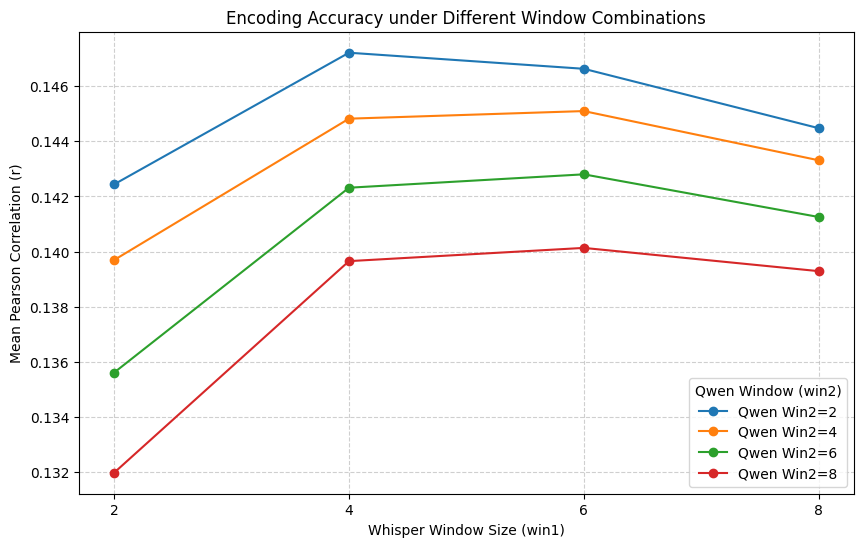


Grid search complete. Plot and data saved.


In [5]:
#比较不同窗口的代码
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from utils import concat_feature, fit_encoding_cv

# --- 1. 配置参数 ---
WIN1_LIST = [2, 4, 6, 8]  # Whisper 窗口
WIN2_LIST = [2, 4, 6, 8]  # Qwen 窗口

FEATURE_DIR = './npyall/'
target_dim = 250
FEATURE_FILES = {
    'whisper': 'whisper_win4_layer12_mean.npy',
    'qwen': 'qwen_win200_layer18_Mlast_TRmax.npy'
}

# 加载 fMRI 数据 (只需加载一次)
fmris = np.load('21styear_all_subs_rois.npy', allow_pickle=True).item()
all_subjects = list(fmris.keys())

# 交叉验证配置
kfold, alphas = 5, [10000., 100000., 1000000.]
outer_cv = KFold(n_splits=kfold, shuffle=False)
excluded_start, excluded_end = 10, 10

# 存储最终结果：{(win1, win2): mean_score}
grid_results = {}

# --- 2. 嵌套循环遍历组合 ---
for w1 in WIN1_LIST:
    for w2 in WIN2_LIST:
        print(f"\n>>> Running Config: Whisper_win={w1}, Qwen_win={w2} <<<")
        
        # 处理特征
        raw_processed_parts = []
        current_configs = {
            'whisper': {'file': FEATURE_FILES['whisper'], 'offset': 7, 'window': w1},
            'qwen': {'file': FEATURE_FILES['qwen'], 'offset': 7, 'window': w2}
        }

        for name, cfg in current_configs.items():
            path = os.path.join(FEATURE_DIR, cfg['file'])
            feat = np.load(path)
            feat_delayed = concat_feature(feat, window=cfg['window'], offset=cfg['offset'])
            feat_flattened = feat_delayed.reshape(feat_delayed.shape[0], -1)
            raw_processed_parts.append(feat_flattened)

        # 对齐长度并拼接
        min_len = min(p.shape[0] for p in raw_processed_parts)
        big_feature = np.concatenate([p[:min_len] for p in raw_processed_parts], axis=1)

        # 标准化与 PCA
        big_feature_std = StandardScaler().fit_transform(big_feature)
        fir_features = PCA(n_components=target_dim).fit_transform(big_feature_std)

        # 运行编码模型
        current_combo_scores = []
        for sub in all_subjects:
            y = fmris[sub][:min_len]
            try:
                model, corr_map = fit_encoding_cv(
                    X=fir_features, y=y, cv_splitter=outer_cv,
                    alphas=alphas, excluded_start=excluded_start, excluded_end=excluded_end
                )
                current_combo_scores.append(np.mean(corr_map))
            except Exception as e:
                print(f"Error for {sub}: {e}")
        
        # 记录该组合的平均分
        avg_score = np.mean(current_combo_scores)
        grid_results[(w1, w2)] = avg_score
        print(f"Result for w1={w1}, w2={w2}: Mean Corr = {avg_score:.4f}")

# --- 3. 绘制折线图 ---
plt.figure(figsize=(10, 6))

for w2 in WIN2_LIST:
    # 提取固定 w2 时，随 w1 变化的分数
    scores_for_line = [grid_results[(w1, w2)] for w1 in WIN1_LIST]
    plt.plot(WIN1_LIST, scores_for_line, marker='o', label=f'Qwen Win2={w2}')

plt.xlabel('Whisper Window Size (win1)')
plt.ylabel('Mean Pearson Correlation (r)')
plt.title('Encoding Accuracy under Different Window Combinations')
plt.xticks(WIN1_LIST)
plt.legend(title='Qwen Window (win2)')
plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig('window_combination_analysis.png', dpi=300)
plt.show()

# 保存详细数据到文本
with open('window_grid_search_results.txt', 'w') as f:
    f.write("win1\twin2\tmean_corr\n")
    for (w1, w2), score in grid_results.items():
        f.write(f"{w1}\t{w2}\t{score:.4f}\n")

print("\nGrid search complete. Plot and data saved.")


--- Preparing Fused Features ---

Evaluating Fusion Method: Concatenate

Evaluating Fusion Method: Sum

Evaluating Fusion Method: Weighted

Evaluating Fusion Method: Hadamard


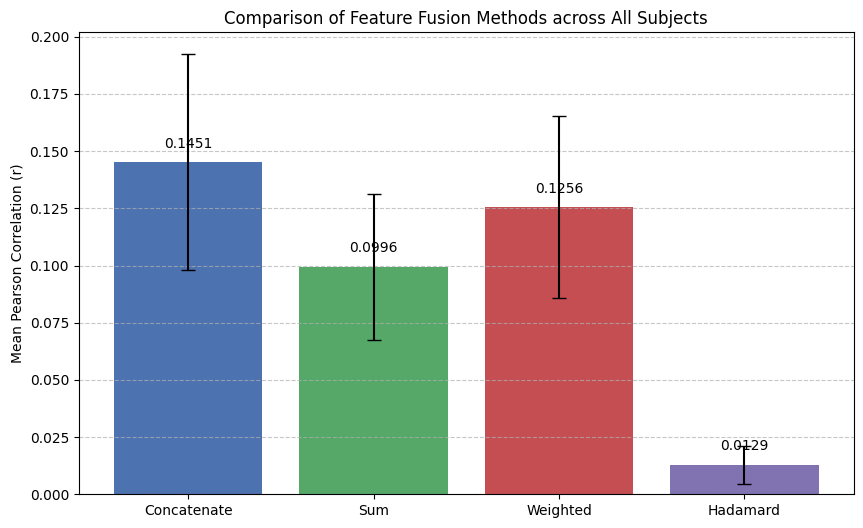


Comparison complete. Plot saved as 'fusion_method_comparison.png'.


In [3]:
#比较不同融合方式的代码
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from utils import concat_feature, fit_encoding_cv

# --- 1. 配置参数 ---
win1, win2 = 4, 4
FEATURE_DIR = './npyall/'
target_dim = 250
configs = {
    'whisper': {'file': 'whisper_win4_layer12_mean.npy', 'offset': 7, 'window': win1},
    'qwen': {'file': 'qwen_win200_layer18_Mlast_TRmax.npy', 'offset': 7, 'window': win2}
}

# --- 2. 原始特征延迟处理 ---
processed_feats = {}
for name, cfg in configs.items():
    path = os.path.join(FEATURE_DIR, cfg['file'])
    feat = np.load(path)
    feat_delayed = concat_feature(feat, window=cfg['window'], offset=cfg['offset'])
    feat_flattened = feat_delayed.reshape(feat_delayed.shape[0], -1)
    # 标准化
    feat_std = StandardScaler().fit_transform(feat_flattened)
    processed_feats[name] = feat_std

# 确保长度一致
min_len = min(f.shape[0] for f in processed_feats.values())
f_whisper = processed_feats['whisper'][:min_len]
f_qwen = processed_feats['qwen'][:min_len]

# --- 3. 定义不同的融合方法 ---
print("\n--- Preparing Fused Features ---")
fusion_methods = {}

# A. 拼接融合 (Concatenate + PCA)
concat_raw = np.concatenate([f_whisper, f_qwen], axis=1)
fusion_methods['Concatenate'] = PCA(n_components=target_dim).fit_transform(concat_raw)

# 为了后续的加和/乘积，需要先将各模态分别降维到 250
pca_whisper = PCA(n_components=target_dim).fit_transform(f_whisper)
pca_qwen = PCA(n_components=target_dim).fit_transform(f_qwen)

# B. 直接加和 (Sum)
fusion_methods['Sum'] = pca_whisper + pca_qwen

# C. 加权融合 (Weighted: Text/Qwen 0.3, Audio/Whisper 0.7)
fusion_methods['Weighted'] = 0.7 * pca_whisper + 0.3 * pca_qwen

# D. Hadamard 积 (Hadamard)
fusion_methods['Hadamard'] = pca_whisper * pca_qwen

# --- 4. 运行编码模型并对比 ---
fmris = np.load('21styear_all_subs_rois.npy', allow_pickle=True).item()
all_subjects = list(fmris.keys())
kfold, alphas = 5, [10000., 100000., 1000000.]
outer_cv = KFold(n_splits=kfold, shuffle=False)

# 存储结果：{method_name: [sub1_score, sub2_score, ...]}
comparison_results = {m: [] for m in fusion_methods.keys()}

for method_name, X_features in fusion_methods.items():
    print(f"\nEvaluating Fusion Method: {method_name}")
    for sub in all_subjects:
        y = fmris[sub][:min_len]
        try:
            # 这里的 fit_encoding_cv 是你原有的工具函数
            model, corr_map = fit_encoding_cv(
                X=X_features, y=y, cv_splitter=outer_cv,
                alphas=alphas, excluded_start=10, excluded_end=10
            )
            comparison_results[method_name].append(np.mean(corr_map))
        except Exception as e:
            print(f"Error for {sub} in {method_name}: {e}")

# --- 5. 绘图与对比分析 ---
methods = list(comparison_results.keys())
avg_scores = [np.mean(comparison_results[m]) for m in methods]
std_scores = [np.std(comparison_results[m]) for m in methods]

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, avg_scores, yerr=std_scores, capsize=5, color=['#4C72B0', '#55A868', '#C44E52', '#8172B2'])
plt.ylabel('Mean Pearson Correlation (r)')
plt.title('Comparison of Feature Fusion Methods across All Subjects')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 在柱状图上方标注数值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom')

plt.savefig('fusion_method_comparison.png')
plt.show()

# 保存详细文本结果
with open('fusion_comparison_report.txt', 'w') as f:
    f.write("Fusion Method Comparison Report\n")
    f.write("="*30 + "\n")
    for m in methods:
        f.write(f"{m}: Mean Corr = {np.mean(comparison_results[m]):.4f} (±{np.std(comparison_results[m]):.4f})\n")

print("\nComparison complete. Plot saved as 'fusion_method_comparison.png'.")


--- Preparing Fused Features ---

Evaluating Fusion Method: Concat (Aud+Txt)

Evaluating Fusion Method: Concat (Txt+Aud)

Evaluating Fusion Method: Sum

Evaluating Fusion Method: Weighted

Evaluating Fusion Method: Hadamard


C:\Users\18035\AppData\Local\Temp\ipykernel_22420\2446891633.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set3')(np.linspace(0, 1, len(methods)))


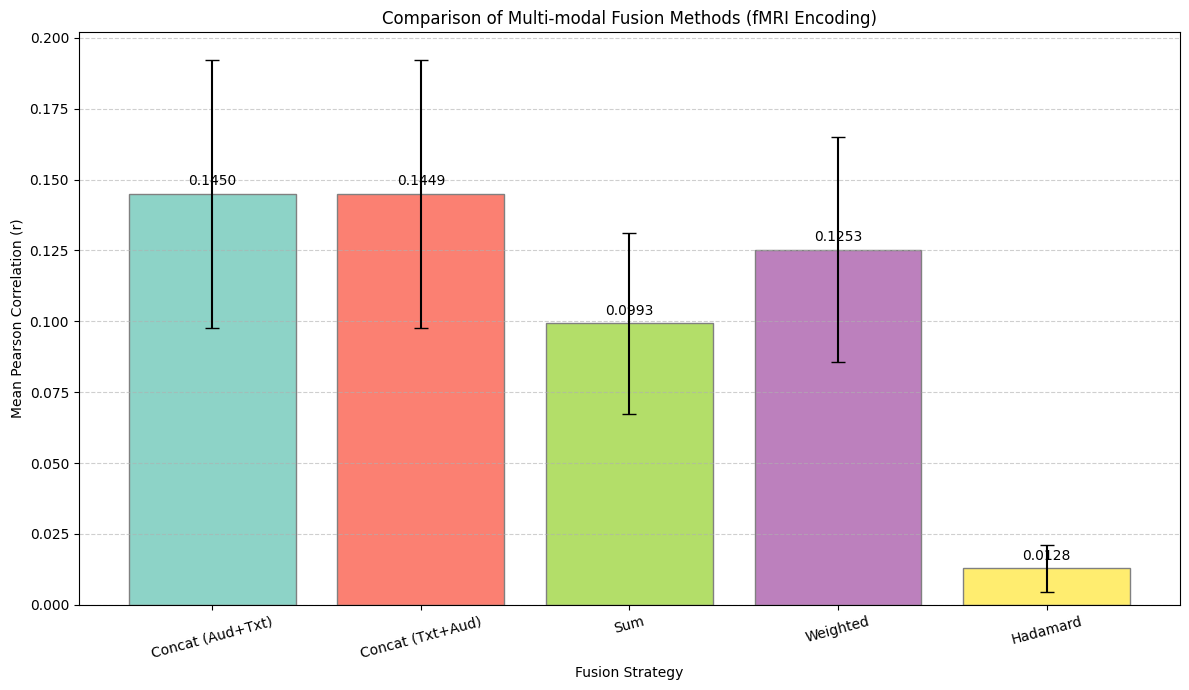


Comparison complete. Results saved to 'fusion_method_comparison_extended.png' and 'fusion_comparison_report.txt'.


In [4]:
#再加入前后对比，画出不同融合的效果
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from utils import concat_feature, fit_encoding_cv

# --- 1. 配置参数 ---
win1, win2 = 4, 4
FEATURE_DIR = './npyall/'
target_dim = 250
configs = {
    'whisper': {'file': 'whisper_win4_layer12_mean.npy', 'offset': 7, 'window': win1},
    'qwen': {'file': 'qwen_win200_layer18_Mlast_TRmax.npy', 'offset': 7, 'window': win2}
}

# --- 2. 原始特征延迟处理 ---
processed_feats = {}
for name, cfg in configs.items():
    path = os.path.join(FEATURE_DIR, cfg['file'])
    feat = np.load(path)
    feat_delayed = concat_feature(feat, window=cfg['window'], offset=cfg['offset'])
    feat_flattened = feat_delayed.reshape(feat_delayed.shape[0], -1)
    # 标准化
    feat_std = StandardScaler().fit_transform(feat_flattened)
    processed_feats[name] = feat_std

# 确保长度一致
min_len = min(f.shape[0] for f in processed_feats.values())
f_whisper = processed_feats['whisper'][:min_len]
f_qwen = processed_feats['qwen'][:min_len]

# --- 3. 定义不同的融合方法 ---
print("\n--- Preparing Fused Features ---")
fusion_methods = {}

# A1. 拼接融合 (Audio + Text) 然后 PCA
concat_at = np.concatenate([f_whisper, f_qwen], axis=1)
fusion_methods['Concat (Aud+Txt)'] = PCA(n_components=target_dim).fit_transform(concat_at)

# A2. 拼接融合 (Text + Audio) 然后 PCA —— 这是你新增的要求
concat_ta = np.concatenate([f_qwen, f_whisper], axis=1)
fusion_methods['Concat (Txt+Aud)'] = PCA(n_components=target_dim).fit_transform(concat_ta)

# 为了后续的加和/乘积，需要先将各模态分别降维到 250
pca_whisper = PCA(n_components=target_dim).fit_transform(f_whisper)
pca_qwen = PCA(n_components=target_dim).fit_transform(f_qwen)

# B. 直接加和 (Sum)
fusion_methods['Sum'] = pca_whisper + pca_qwen

# C. 加权融合 (Weighted: Text 0.3, Audio 0.7)
fusion_methods['Weighted'] = 0.7 * pca_whisper + 0.3 * pca_qwen

# D. Hadamard 积 (Hadamard)
fusion_methods['Hadamard'] = pca_whisper * pca_qwen

# --- 4. 运行编码模型并对比 ---
# 加载 fMRI 数据
fmris = np.load('21styear_all_subs_rois.npy', allow_pickle=True).item()
all_subjects = list(fmris.keys())
kfold, alphas = 5, [10000., 100000., 1000000.]
outer_cv = KFold(n_splits=kfold, shuffle=False)

# 存储结果：{method_name: [sub1_score, sub2_score, ...]}
comparison_results = {m: [] for m in fusion_methods.keys()}

for method_name, X_features in fusion_methods.items():
    print(f"\nEvaluating Fusion Method: {method_name}")
    for sub in all_subjects:
        # 获取对应受试者数据并对齐长度
        y = fmris[sub][:min_len]
        try:
            # 使用你的工具函数进行交叉验证
            model, corr_map = fit_encoding_cv(
                X=X_features, y=y, cv_splitter=outer_cv,
                alphas=alphas, excluded_start=10, excluded_end=10
            )
            comparison_results[method_name].append(np.mean(corr_map))
        except Exception as e:
            print(f"Error for {sub} in {method_name}: {e}")

# --- 5. 绘图与对比分析 ---
methods = list(comparison_results.keys())
avg_scores = [np.mean(comparison_results[m]) for m in methods]
std_scores = [np.std(comparison_results[m]) for m in methods]

plt.figure(figsize=(12, 7))
# 使用颜色映射动态生成颜色
colors = plt.cm.get_cmap('Set3')(np.linspace(0, 1, len(methods)))

bars = plt.bar(methods, avg_scores, yerr=std_scores, capsize=5, color=colors, edgecolor='gray')
plt.ylabel('Mean Pearson Correlation (r)')
plt.xlabel('Fusion Strategy')
plt.title('Comparison of Multi-modal Fusion Methods (fMRI Encoding)')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# 在柱状图上方标注数值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('fusion_method_comparison_extended.png', dpi=300)
plt.show()

# 保存详细文本报告
with open('fusion_comparison_report.txt', 'w') as f:
    f.write("Fusion Method Comparison Report\n")
    f.write("="*40 + "\n")
    f.write(f"Parameters: Target_Dim={target_dim}, KFold={kfold}\n")
    f.write("-"*40 + "\n")
    for m in methods:
        mean_val = np.mean(comparison_results[m])
        std_val = np.std(comparison_results[m])
        f.write(f"{m:<18}: Mean Corr = {mean_val:.4f} (±{std_val:.4f})\n")

print("\nComparison complete. Results saved to 'fusion_method_comparison_extended.png' and 'fusion_comparison_report.txt'.")

In [37]:
#打印准确率
# ======================================================
# Encoding model: 特征 × PCA × FIR × 多被试评测
# ======================================================

import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from utils import fit_encoding_cv, concat_feature

# ---------- 1. fMRI 数据 ----------
fmris = np.load('21styear_all_subs_rois.npy', allow_pickle=True).item()
all_subjects = list(fmris.keys())
print(f"Loaded fMRI data for {len(all_subjects)} subjects")

# ---------- 2. 参数设置 ----------
kfold = 5
outer_cv = KFold(n_splits=kfold, shuffle=False)
alphas = [10000., 100000., 1000000.]
excluded_start, excluded_end = 10, 10

# PCA & FIR 参数
pca_dim = 250
fir_window = 4
fir_offset = 7

# ---------- 3. 存储所有特征的结果 ----------
all_feature_summary = {}

# ======================================================
# 4. 主循环：每种特征
# ======================================================
for modelname, aligned_tr_feats in all_features.items():

    print("\n" + "=" * 70)
    print(f"Processing feature: {modelname}")
    print(f"Original feature shape: {aligned_tr_feats.shape}")
    print("=" * 70)

    # ==================================================
    # 4.1 PCA 降维
    # ==================================================
    scaler = StandardScaler()
    aligned_feats_std = scaler.fit_transform(aligned_tr_feats)

    pca = PCA(n_components=pca_dim, random_state=0)
    aligned_tr_feats = pca.fit_transform(aligned_feats_std)

    print(f"After PCA: {aligned_tr_feats.shape}")

    # ==================================================
    # 4.2 血液动力学延迟（FIR）
    # ==================================================
    fir_features = concat_feature(
        aligned_tr_feats,
        window=fir_window,
        offset=fir_offset
    )
    fir_features = fir_features.reshape(fir_features.shape[0], -1)

    print(f"After FIR: {fir_features.shape}")

    # ==================================================
    # 4.3 多被试 encoding
    # ==================================================
    all_sub_scores = []
    all_sub_results = {}

    for sub in all_subjects:
        print(f"Subject {sub}...", end=" ")

        try:
            model, corr_map = fit_encoding_cv(
                X=fir_features,
                y=fmris[sub],
                cv_splitter=outer_cv,
                alphas=alphas,
                excluded_start=excluded_start,
                excluded_end=excluded_end
            )

            mean_cv_corr = np.mean(corr_map)
            all_sub_scores.append(mean_cv_corr)

            all_sub_results[sub] = {
                'mean_corr': mean_cv_corr,
                'corr_map': corr_map
            }

            print(f"mean CV corr = {mean_cv_corr:.4f}")

        except Exception as e:
            print(f"FAILED ({e})")
            continue

    # ==================================================
    # 4.4 统计 & 保存
    # ==================================================
    all_sub_scores = np.array(all_sub_scores)
    mean_score = np.mean(all_sub_scores)
    std_score = np.std(all_sub_scores)

    print("\n>>> Feature:", modelname)
    print(f">>> Mean CV corr: {mean_score:.4f} ± {std_score:.4f}")

    all_feature_summary[modelname] = {
        'mean': mean_score,
        'std': std_score,
        'per_subject': all_sub_results
    }

    output_txt = f'encoding_accuracy_all_subjects_for_{modelname}_PCA{pca_dim}_FIR.txt'
    with open(output_txt, 'w') as f:
        f.write(f"Feature: {modelname}\n")
        f.write(f"PCA dim: {pca_dim}\n")
        f.write(f"FIR window: {fir_window}, offset: {fir_offset}\n")
        f.write(f"Mean CV corr: {mean_score:.4f} ± {std_score:.4f}\n\n")

        for sub in all_sub_results:
            f.write(f"Subject {sub}: {all_sub_results[sub]['mean_corr']:.4f}\n")

    print(f"Results saved to: {output_txt}")

# ======================================================
# 5. 最终汇总
# ======================================================
print("\n" + "#" * 70)
print("Final Summary (All Features, PCA + FIR)")
print("#" * 70)

for feat, res in all_feature_summary.items():
    print(f"{feat:12s} : {res['mean']:.4f} ± {res['std']:.4f}")


Loaded fMRI data for 25 subjects

Processing feature: clap
Original feature shape: (2249, 1024)
After PCA: (2249, 250)
After FIR: (2249, 1000)
Subject 75... mean CV corr = 0.1791
Subject 131... mean CV corr = 0.1308
Subject 190... mean CV corr = 0.1331
Subject 201... mean CV corr = 0.1446
Subject 235... mean CV corr = 0.1466
Subject 244... mean CV corr = 0.0849
Subject 249... mean CV corr = 0.1655
Subject 254... mean CV corr = 0.1181
Subject 255... mean CV corr = 0.1827
Subject 256... mean CV corr = 0.1314
Subject 257... mean CV corr = 0.0934
Subject 258... mean CV corr = 0.1584
Subject 259... mean CV corr = 0.0865
Subject 260... mean CV corr = 0.1348
Subject 261... mean CV corr = 0.1906
Subject 262... mean CV corr = 0.0968
Subject 263... mean CV corr = 0.1743
Subject 264... mean CV corr = 0.0897
Subject 265... mean CV corr = 0.0779
Subject 266... mean CV corr = 0.0660
Subject 267... mean CV corr = 0.1452
Subject 268... mean CV corr = 0.0396
Subject 269... mean CV corr = 0.1019
Subject

In [32]:
#对75号被试可视化
# ======================================================
# Subject 75 | 每个特征重新建模 + 可视化 + 保存
# ======================================================

import numpy as np
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from utils import (
    fit_encoding_cv,
    concat_feature,
    extract_hemi_data_from_files
)

from brainspace.plotting.surface_plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from neuromaps.datasets import fetch_atlas


# ======================================================
# 1. 基础参数
# ======================================================
sub_id = 75

pca_dim = 250
fir_window = 4
fir_offset = 7

outer_cv = KFold(n_splits=5, shuffle=False)
alphas = [10000., 100000., 1000000.]
excluded_start, excluded_end = 10, 10

save_dir = Path('./results/sub75_feature_maps/')
save_dir.mkdir(parents=True, exist_ok=True)


# ======================================================
# 2. fMRI 数据
# ======================================================
fmris = np.load('21styear_all_subs_rois.npy', allow_pickle=True).item()
y = fmris[sub_id]                      # (n_TRs, n_rois)
n_rois = y.shape[1]

print(f'Loaded Subject {sub_id}, fMRI shape: {y.shape}')


# ======================================================
# 3. 脑表面 & ROI 模板
# ======================================================
fslr = fetch_atlas('fsaverage', '41k', data_dir='.')

surf_lh = read_surface(str(fslr['inflated'].L))
surf_rh = read_surface(str(fslr['inflated'].R))

tpl_files = list(Path('.').glob('*MMP*gii'))
whole_brain_rois = extract_hemi_data_from_files(
    tpl_files,
    is_label=True,
    return_list=False
).astype(int)

print('ROI template shape:', whole_brain_rois.shape)


# ======================================================
# 4. 主循环：每个特征
# ======================================================
for feat_name, aligned_tr_feats in all_features.items():

    print(f'\n===== Subject {sub_id} | Feature: {feat_name} =====')
    print('Original feature shape:', aligned_tr_feats.shape)

    # --------------------------------------------------
    # 4.1 PCA
    # --------------------------------------------------
    scaler = StandardScaler()
    feats_std = scaler.fit_transform(aligned_tr_feats)

    pca = PCA(n_components=pca_dim, random_state=0)
    feats_pca = pca.fit_transform(feats_std)

    print('After PCA:', feats_pca.shape)

    # --------------------------------------------------
    # 4.2 FIR（血液动力学延迟）
    # --------------------------------------------------
    fir_features = concat_feature(
        feats_pca,
        window=fir_window,
        offset=fir_offset
    )
    fir_features = fir_features.reshape(fir_features.shape[0], -1)

    print('After FIR:', fir_features.shape)

    # --------------------------------------------------
    # 4.3 Encoding（只用 75 号被试）
    # --------------------------------------------------
    _, corr_map = fit_encoding_cv(
        X=fir_features,
        y=y,
        cv_splitter=outer_cv,
        alphas=alphas,
        excluded_start=excluded_start,
        excluded_end=excluded_end
    )

    print('Mean CV corr:', np.nanmean(corr_map))

    # --------------------------------------------------
    # 4.4 ROI → vertex
    # --------------------------------------------------
    whole_brain_corrs = np.zeros(whole_brain_rois.shape, dtype=np.float32)

    for roi_ind in np.unique(whole_brain_rois[whole_brain_rois != 0]):
        whole_brain_corrs[whole_brain_rois == roi_ind] = corr_map[roi_ind - 1]

    # medial wall
    whole_brain_corrs[whole_brain_rois == 0] = np.nan
    # 只显示正相关
    whole_brain_corrs[whole_brain_corrs < 0.] = np.nan

    # --------------------------------------------------
    # 4.5 可视化并保存
    # --------------------------------------------------
    out_png = save_dir / f'sub{sub_id}_{feat_name}.png'

    plot_hemispheres(
        surf_lh,
        surf_rh,
        array_name=whole_brain_corrs,
        nan_color=(0.8, 0.8, 0.8, 1),
        background=(1, 1, 1),
        size=(1200, 350),
        embed_nb=False,
        interactive=False,
        transparent_bg=False,
        color_bar=False,
        cmap='coolwarm',
        zoom=1.2,
        screenshot=True,
        filename=str(out_png)
    )

    print(f'Saved: {out_png}')


print('\nAll feature maps saved.')


Loaded Subject 75, fMRI shape: (2249, 360)
ROI template shape: (81924,)

===== Subject 75 | Feature: clap =====
Original feature shape: (2249, 1024)
After PCA: (2249, 250)
After FIR: (2249, 1000)
Mean CV corr: 0.17908464681726338
Saved: results\sub75_feature_maps\sub75_clap.png

===== Subject 75 | Feature: whisper =====
Original feature shape: (2249, 768)
After PCA: (2249, 250)
After FIR: (2249, 1000)
Mean CV corr: 0.20069512864279168
Saved: results\sub75_feature_maps\sub75_whisper.png

===== Subject 75 | Feature: qwen =====
Original feature shape: (2249, 1536)
After PCA: (2249, 250)
After FIR: (2249, 1000)
Mean CV corr: 0.14545033109550484
Saved: results\sub75_feature_maps\sub75_qwen.png

===== Subject 75 | Feature: wav2vec2 =====
Original feature shape: (2249, 768)
After PCA: (2249, 250)
After FIR: (2249, 1000)
Mean CV corr: 0.19590254563901952
Saved: results\sub75_feature_maps\sub75_wav2vec2.png

===== Subject 75 | Feature: wavlm =====
Original feature shape: (2249, 768)
After PCA: 

In [47]:
#PCA降维后的
import os
import numpy as np
from utils import fit_encoding_cv, concat_feature
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ======================================================
# 1. fMRI 数据
# ======================================================
fmris = np.load('21styear_all_subs_rois.npy', allow_pickle=True).item()

# ======================================================
# 2. Encoding 参数
# ======================================================
outer_cv = KFold(n_splits=5, shuffle=False)
alphas = [10000., 100000., 1000000.]
excluded_start, excluded_end = 10, 10

# PCA & FIR 参数
pca_dim = 250
fir_window = 4
fir_offset = 7

# ======================================================
# 3. 特征类型映射
# ======================================================
feature_type = {
    'clap': 'clap',
    'whisper': 'whisper',
    'wav2vec2': 'wav2vec2',
    'wavlm': 'wavlm',
    'hubert': 'hubert',
    'gpt': 'gpt',
    'qwen': 'qwen',
    'deepseek': 'deepseek',
    'imagebind': 'imagebind'
}

type_to_int = {
    'clap': 0,
    'whisper': 1,
    'wav2vec2': 2,
    'wavlm': 3,
    'hubert': 4,
    'gpt': 5,
    'qwen': 6,
    'deepseek': 7,
    'imagebind': 8
}

# ======================================================
# 4. 主循环：被试
# ======================================================
all_sub_results = {}

for sub in fmris.keys():
    print(f'\n===== Subject {sub} =====')

    y = fmris[sub]                # (n_TRs, n_rois)
    n_rois = y.shape[1]

    feature_corr_maps = {}        # feature_name -> (n_rois,)

    # --------------------------------------------------
    # Step 1: 每个特征单独 PCA + FIR + encoding
    # --------------------------------------------------
    for feat_name, aligned_tr_feats in all_features.items():
        print(f'  Processing feature: {feat_name}')

        # ---------- PCA ----------
        scaler = StandardScaler()
        feats_std = scaler.fit_transform(aligned_tr_feats)

        pca = PCA(n_components=pca_dim, random_state=0)
        feats_pca = pca.fit_transform(feats_std)

        # ---------- FIR ----------
        fir_features = concat_feature(
            feats_pca,
            window=fir_window,
            offset=fir_offset
        )
        fir_features = fir_features.reshape(fir_features.shape[0], -1)

        # ---------- Encoding ----------
        _, corr_map = fit_encoding_cv(
            X=fir_features,
            y=y,
            cv_splitter=outer_cv,
            alphas=alphas,
            excluded_start=excluded_start,
            excluded_end=excluded_end
        )

        feature_corr_maps[feat_name] = corr_map

    # --------------------------------------------------
    # Step 2: 堆成 (n_features, n_rois)
    # --------------------------------------------------
    feature_names = list(feature_corr_maps.keys())
    n_features = len(feature_names)

    corr_matrix = np.zeros((n_features, n_rois))
    for i, feat_name in enumerate(feature_names):
        corr_matrix[i] = feature_corr_maps[feat_name]

    # --------------------------------------------------
    # Step 3: ROI 级别特征竞争（只保留正相关）
    # --------------------------------------------------
    corr_matrix_pos = corr_matrix.copy()
    corr_matrix_pos[corr_matrix_pos <= 0] = np.nan

    best_feature_per_roi = []
    best_type_per_roi = np.full(n_rois, np.nan)

    for roi in range(n_rois):
        roi_corrs = corr_matrix_pos[:, roi]

        if np.all(np.isnan(roi_corrs)):
            best_feature_per_roi.append(None)
            continue

        best_idx = np.nanargmax(roi_corrs)
        best_feat = feature_names[best_idx]

        best_feature_per_roi.append(best_feat)
        best_type_per_roi[roi] = type_to_int[feature_type[best_feat]]

    # --------------------------------------------------
    # Step 4: 保存结果
    # --------------------------------------------------
    save_dir = './results/feature_competition/'
    os.makedirs(save_dir, exist_ok=True)

    np.savez(
        os.path.join(save_dir, f'subject_{sub}_feature_competition.npz'),
        corr_matrix=corr_matrix,
        feature_names=np.array(feature_names),
        best_feature_per_roi=np.array(best_feature_per_roi, dtype=object),
        best_type_per_roi=best_type_per_roi
    )

    all_sub_results[sub] = {
        'feature_corr_maps': feature_corr_maps,
        'corr_matrix': corr_matrix,
        'best_feature_per_roi': best_feature_per_roi
    }

    print('  Done.')



===== Subject 75 =====
  Processing feature: clap
  Processing feature: whisper
  Processing feature: imagebind
  Processing feature: wav2vec2
  Processing feature: wavlm
  Processing feature: hubert
  Processing feature: gpt
  Processing feature: deepseek
  Processing feature: qwen
  Done.

===== Subject 131 =====
  Processing feature: clap
  Processing feature: whisper
  Processing feature: imagebind
  Processing feature: wav2vec2
  Processing feature: wavlm
  Processing feature: hubert
  Processing feature: gpt
  Processing feature: deepseek
  Processing feature: qwen
  Done.

===== Subject 190 =====
  Processing feature: clap
  Processing feature: whisper
  Processing feature: imagebind
  Processing feature: wav2vec2
  Processing feature: wavlm
  Processing feature: hubert
  Processing feature: gpt
  Processing feature: deepseek
  Processing feature: qwen
  Done.

===== Subject 201 =====
  Processing feature: clap
  Processing feature: whisper
  Processing feature: imagebind
  Pro

In [48]:
#可视化
from brainspace.plotting.surface_plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from neuromaps.datasets import fetch_atlas
from utils import extract_hemi_data_from_files

fslr = fetch_atlas('fsaverage', '41k', data_dir='.')
# 读入表面模板文件，用于后续可视化
# inflated表示膨胀后的表面网格，fslr['inflated']是一个字典，包含左右两个表面文件的路径
# （pathlib.WindowsPath对象，需要转换成str）
surf_lh = read_surface(str(fslr['inflated'].L))
surf_rh = read_surface(str(fslr['inflated'].R))

path = Path('.')
tpl_files = list(path.glob('*MMP*gii'))
whole_brain_rois = extract_hemi_data_from_files(tpl_files, is_label=True, return_list=False).astype(int)


import numpy as np
import os

sub = 75  # 举例
npz_path = f'./results/feature_competition/subject_{sub}_feature_competition.npz'#subject_75_voxelwise_feature_competition

data = np.load(npz_path, allow_pickle=True)
roi_pref_type = data['best_type_per_roi']   # (n_rois,)codes\results\feature_competition_voxelwise\subject_75_voxelwise_feature_competition.npz


# --- Step 6: ROI -> 皮层 ---
whole_brain_pref = np.zeros(whole_brain_rois.shape, dtype=np.float32)

for roi_ind in np.unique(whole_brain_rois[whole_brain_rois != 0]):
    whole_brain_pref[whole_brain_rois == roi_ind] = roi_pref_type[roi_ind - 1]

# medial wall
whole_brain_pref[whole_brain_rois == 0] = np.nan

# --- 输出路径 ---
output_dir = './output/feature_preference_maps/'
os.makedirs(output_dir, exist_ok=True)

filename = f'Subject_{sub}_dominant_feature_type.png'
filepath = os.path.join(output_dir, filename)

print(f"Saving brain map to: {filepath}")
plot_hemispheres(surf_lh, surf_rh,
                     array_name=whole_brain_pref,
                     nan_color=(0.8, 0.8, 0.8, 1),
                     background=(1, 1, 1),
                     size=(1000, 300),
                     embed_nb=False, 
                     color_bar=False,
                     interactive=False, # 非交互模式，适用于截图
                     cmap='tab10',
                     zoom=1.2,
                     #label_text=subject_label, # 使用官方参数传递标签文本
                     transparent_bg=False, # 确保背景不透明，适用于截图
                     # --- 核心修改：使用正确的截图参数 ---
                     screenshot=True, # 启用截图模式
                     filename=filepath # 指定保存文件路径
)

Saving brain map to: ./output/feature_preference_maps/Subject_75_dominant_feature_type.png


'd:\\a-kaggle\\codes\\output\\feature_preference_maps\\Subject_75_dominant_feature_type.png'

In [55]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- 绘图相关库 ---
from brainspace.plotting.surface_plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from neuromaps.datasets import fetch_atlas
from utils import extract_hemi_data_from_files

# ======================================================
# 1. 配置参数与映射
# ======================================================
# 硬阈值：低于 0.1 的相关性被视为不显著（根据你提供的 Mean CV 估算）
R_THRESHOLD = 0.15  

type_to_int = {
    'clap': 0, 'whisper': 1, 'wav2vec2': 2, 'wavlm': 3,
    'hubert': 4, 'gpt': 5, 'qwen': 6, 'deepseek': 7, 'imagebind': 8
}

feature_type = {k: k for k in type_to_int.keys()} # 模型名到类型的映射

# ======================================================
# 2. 准备表面模板 (Atlas)
# ======================================================
fslr = fetch_atlas('fsaverage', '41k', data_dir='.')
surf_lh = read_surface(str(fslr['inflated'].L))
surf_rh = read_surface(str(fslr['inflated'].R))

# 加载 ROI 分区定义
path = Path('.')
tpl_files = list(path.glob('*MMP*gii'))
whole_brain_rois = extract_hemi_data_from_files(tpl_files, is_label=True, return_list=False).astype(int)

# ======================================================
# 3. 处理被试数据并计算“特征竞争”
# ======================================================
sub = 75  # 举例
npz_path = f'./results/feature_competition/subject_{sub}_feature_competition.npz'

# 如果你已经跑完了之前的 encoding，可以直接加载 npz
data = np.load(npz_path, allow_pickle=True)
corr_matrix = data['corr_matrix']  # 形状: (n_features, n_rois)
feature_names = data['feature_names']
n_rois = corr_matrix.shape[1]

# --- 核心改进：执行带阈值的特征竞争 ---
best_type_per_roi = np.full(n_rois, np.nan)

for roi in range(n_rois):
    roi_corrs = corr_matrix[:, roi]
    
    # 找到该 ROI 中表现最好的模型
    max_corr = np.max(roi_corrs)
    best_idx = np.argmax(roi_corrs)
    
    # 只有当最大相关系数超过阈值时，才给该 ROI 涂色
    if max_corr > R_THRESHOLD:
        best_feat = feature_names[best_idx]
        best_type_per_roi[roi] = type_to_int[feature_type[best_feat]]
    else:
        # 低于阈值的 ROI 保持为 NaN (后续渲染为灰色)
        best_type_per_roi[roi] = np.nan

# ======================================================
# 4. 映射到皮层表面并绘图
# ======================================================
# 初始化全脑顶点数据
whole_brain_pref = np.full(whole_brain_rois.shape, np.nan, dtype=np.float32)

# 将 ROI 的优胜者编号映射到每一个顶点
for roi_ind in np.unique(whole_brain_rois[whole_brain_rois > 0]):
    # 注意：roi_ind 通常从 1 开始，对应数组索引 roi_ind - 1
    if roi_ind - 1 < len(best_type_per_roi):
        whole_brain_pref[whole_brain_rois == roi_ind] = best_type_per_roi[roi_ind - 1]

# 强制将内侧壁 (Medial Wall) 设为 NaN
whole_brain_pref[whole_brain_rois == 0] = np.nan

# --- 输出与保存 ---
output_dir = './output/feature_preference_maps/'
os.makedirs(output_dir, exist_ok=True)
filepath = os.path.join(output_dir, f'Subject_{sub}_refined_map.png')

print(f"正在生成优化后的脑图并保存至: {filepath}")

plot_hemispheres(surf_lh, surf_rh,
                 array_name=whole_brain_pref,
                 nan_color=(0.8, 0.8, 0.8, 1), # 显著性不足或内侧壁显示为浅灰色
                 background=(1, 1, 1),
                 size=(1200, 400),
                 embed_nb=False, 
                 color_bar=False,
                 cmap='tab10',  # 0-8 映射到 tab10 颜色
                 zoom=1.2,
                 screenshot=True,
                 transparent_bg=False,
                 filename=filepath)

正在生成优化后的脑图并保存至: ./output/feature_preference_maps/Subject_75_refined_map.png


'd:\\a-kaggle\\codes\\output\\feature_preference_maps\\Subject_75_refined_map.png'

In [ ]:
#太乱了，只保留三个颜色
import numpy as np
import os

sub = 75
npz_path = f'./results/feature_competition/subject_{sub}_feature_competition.npz'

data = np.load(npz_path, allow_pickle=True)
roi_pref_type = data['best_type_per_roi']   # (n_rois,)

# -------- 新增：模型 → 模态 重编码 --------
# 1 = Audio, 2 = Text, 3 = Multimodal
model_type_to_modality = {
    0: 2,  # clap
    1: 2,  # whisper
    2: 0,  # wav2vec2
    3: 0,  # wavlm
    4: 0,  # hubert
    5: 1,  # gpt
    6: 1,  # qwen
    7: 1,  # deepseek
    8: 2   # imagebind
}

roi_pref_modality = np.full_like(roi_pref_type, np.nan)

for i, t in enumerate(roi_pref_type):
    if np.isnan(t):
        continue
    roi_pref_modality[i] = model_type_to_modality[int(t)]

# -------- ROI → 皮层 --------
whole_brain_pref = np.zeros(whole_brain_rois.shape, dtype=np.float32)

for roi_ind in np.unique(whole_brain_rois[whole_brain_rois != 0]):
    whole_brain_pref[whole_brain_rois == roi_ind] = roi_pref_modality[roi_ind - 1]

# medial wall
whole_brain_pref[whole_brain_rois == 0] = np.nan

# -------- 输出 --------
output_dir = './output/feature_preference_maps/'
os.makedirs(output_dir, exist_ok=True)

filename = f'Subject_{sub}_dominant_modality.png'
filepath = os.path.join(output_dir, filename)

print(f"Saving brain map to: {filepath}")

plot_hemispheres(
    surf_lh, surf_rh,
    array_name=whole_brain_pref,
    nan_color=(0.8, 0.8, 0.8, 1),
    background=(1, 1, 1),
    size=(1000, 300),
    embed_nb=False,
    color_bar=False,
    interactive=False,
    cmap='tab10',      # 只会用到前 3 个颜色
    zoom=1.2,
    transparent_bg=False,
    screenshot=True,
    filename=filepath
)


Saving brain map to: ./output/feature_preference_maps/Subject_75_dominant_modality.png


'd:\\a-kaggle\\codes\\output\\feature_preference_maps\\Subject_75_dominant_modality.png'

In [13]:
#体素级代码

import os
import numpy as np
from utils import fit_encoding_cv
from sklearn.model_selection import KFold

# ================== 数据加载（体素级） ==================
fmris = np.load('21styear_all_subs_rois.npy', allow_pickle=True).item()

outer_cv = KFold(n_splits=5, shuffle=False)
alphas = [10000., 100000., 1000000.]
excluded_start, excluded_end = 10, 10

feature_type = {
    'clap': 'clap',
    'whisper': 'whisper',
    'wav2vec2': 'wav2vec2',
    'wavlm': 'wavlm',
    'hubert': 'hubert',
    'gpt': 'gpt',
    'qwen': 'qwen',
    'deepseek': 'deepseek',
    'imagebind': 'imagebind'
}

type_to_int = {
    'clap': 1,
    'whisper': 2,
    'wav2vec2': 3,
    'wavlm': 4,
    'hubert': 5,
    'gpt': 6,
    'qwen': 7,
    'deepseek': 8,
    'imagebind': 9
}

# ================== 新增：跨被试体素级模型性能 ==================
# feat_name -> list of voxel-mean scores (one per subject)
model_scores_all_subs = {}

# ================== 主循环：逐被试（体素级） ==================
all_sub_results = {}

for sub in fmris.keys():
    print(f'\n===== Subject {sub} (voxel-wise) =====')

    y = fmris[sub]                  # (n_TRs, n_voxels)
    n_voxels = y.shape[1]

    print(f'  n_voxels = {n_voxels}')

    feature_corr_maps = {}          # feature_name -> (n_voxels,)

    # ---------- Step 1: 每个特征训练 voxel-wise encoding ----------
    for feat_name, X in all_features.items():
        print(f'  Fitting feature: {feat_name}')

        _, corr_map = fit_encoding_cv(
            X=X,
            y=y,
            cv_splitter=outer_cv,
            alphas=alphas,
            excluded_start=excluded_start,
            excluded_end=excluded_end
        )

        # corr_map: (n_voxels,)
        feature_corr_maps[feat_name] = corr_map

    # ---------- 新增：体素级 → 被试级（模型性能） ----------
    for feat_name, corr_map in feature_corr_maps.items():
        # 体素级通常噪声大，建议只统计正相关
        valid_corrs = corr_map[corr_map > 0]

        if len(valid_corrs) == 0:
            mean_score = np.nan
        else:
            mean_score = np.nanmean(valid_corrs)

        if feat_name not in model_scores_all_subs:
            model_scores_all_subs[feat_name] = []

        model_scores_all_subs[feat_name].append(mean_score)

    # ---------- Step 2: 堆成 (n_features, n_voxels) ----------
    feature_names = list(feature_corr_maps.keys())
    n_features = len(feature_names)

    corr_matrix = np.zeros((n_features, n_voxels))
    for i, feat_name in enumerate(feature_names):
        corr_matrix[i] = feature_corr_maps[feat_name]

    # ---------- Step 3: 体素级 winner-take-all ----------
    corr_matrix_pos = corr_matrix.copy()
    corr_matrix_pos[corr_matrix_pos <= 0] = np.nan

    best_feature_per_voxel = []
    best_type_per_voxel = np.full(n_voxels, np.nan)

    for v in range(n_voxels):
        voxel_corrs = corr_matrix_pos[:, v]

        if np.all(np.isnan(voxel_corrs)):
            best_feature_per_voxel.append(None)
            continue

        best_idx = np.nanargmax(voxel_corrs)
        best_feat = feature_names[best_idx]

        best_feature_per_voxel.append(best_feat)
        best_type_per_voxel[v] = type_to_int[feature_type[best_feat]]

    # ---------- Step 4: 保存体素级结果 ----------
    save_dir = './results/feature_competition_voxelwise/'
    os.makedirs(save_dir, exist_ok=True)

    np.savez(
        os.path.join(save_dir, f'subject_{sub}_voxelwise_feature_competition.npz'),
        corr_matrix=corr_matrix,
        feature_names=np.array(feature_names),
        best_feature_per_voxel=np.array(best_feature_per_voxel, dtype=object),
        best_type_per_voxel=best_type_per_voxel
    )

    all_sub_results[sub] = {
        'feature_corr_maps': feature_corr_maps,
        'corr_matrix': corr_matrix,
        'best_feature_per_voxel': best_feature_per_voxel
    }

    print(' Done.')

# ================== 跨被试：体素级模型性能统计 ==================
print('\n===== Voxel-wise model performance across subjects =====')

for feat_name, scores in model_scores_all_subs.items():
    scores = np.array(scores, dtype=float)

    mean_acc = np.nanmean(scores)
    std_acc = np.nanstd(scores)

    print(f'{feat_name:12s}: mean = {mean_acc:.4f}, std = {std_acc:.4f}')



===== Subject 75 (voxel-wise) =====
  n_voxels = 360
  Fitting feature: clap
  Fitting feature: whisper
  Fitting feature: qwen
  Fitting feature: wav2vec2
  Fitting feature: wavlm
  Fitting feature: hubert
  Fitting feature: gpt
  Fitting feature: deepseek
  Fitting feature: imagebind
 Done.

===== Subject 131 (voxel-wise) =====
  n_voxels = 360
  Fitting feature: clap
  Fitting feature: whisper
  Fitting feature: qwen
  Fitting feature: wav2vec2
  Fitting feature: wavlm
  Fitting feature: hubert
  Fitting feature: gpt
  Fitting feature: deepseek
  Fitting feature: imagebind
 Done.

===== Subject 190 (voxel-wise) =====
  n_voxels = 360
  Fitting feature: clap
  Fitting feature: whisper
  Fitting feature: qwen
  Fitting feature: wav2vec2
  Fitting feature: wavlm
  Fitting feature: hubert
  Fitting feature: gpt
  Fitting feature: deepseek
  Fitting feature: imagebind
 Done.

===== Subject 201 (voxel-wise) =====
  n_voxels = 360
  Fitting feature: clap
  Fitting feature: whisper
  Fitti